In [1]:
import json
import pandas as pd
import numpy as np
from typing import Any, Dict, List
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import scienceplots


In [2]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:

with open("with_world_model_shadow_model_3.json") as f:
    data = json.load(f)

def json_to_dataframe(data):
    rows = []

    for top_key, sample in data.items():
        is_train = top_key.startswith("train")

        def process_category(category, label):
            if category in sample:
                for condition, metrics in sample[category].items():
                    target = metrics.get('target', None)

                    world_models = metrics.get('world_models', [])
                    if world_models:
                        avg_world = sum(world_models) / len(world_models)
                    else:
                        avg_world = None 

                    shadow_models = metrics.get('shadow_models', [])
                    if shadow_models:
                        avg_shadow = sum(shadow_models) / len(shadow_models)
                    else:
                        avg_shadow = None  

                    rows.append([condition, target, avg_world, avg_shadow, label])

        if is_train:
            process_category('y_stars', 1)
        else:
            process_category('y_stars', 0)

        process_category('y_NON_stars', 0)

    df = pd.DataFrame(rows, columns=['condition', 'target', 'world_model', 'shadow_model', 'label'])
    return df

df_results = json_to_dataframe(data)
print(df_results.head())


       condition    target  world_model  shadow_model  label
0          fever  0.001101     0.000488      0.001724      1
1          cough  0.000035     0.000075      0.000809      1
2  kidney stones  0.000099     0.004891      0.004396      1
3        nausea,  0.000014     0.000016      0.000146      1
4   hypertension  0.001520     0.008386      0.007676      1


In [4]:
df_results

,condition,target,world_model,shadow_model,label
0,fever,0.001101,4.880952e-04,0.001724,1
1,cough,0.000035,7.485183e-05,0.000809,1
2,kidney stones,0.000099,4.891225e-03,0.004396,1
3,"nausea,",0.000014,1.618784e-05,0.000146,1
4,hypertension,0.001520,8.385511e-03,0.007676,1
...,...,...,...,...,...
654,fullness,0.000003,6.276708e-07,0.000013,0
655,diarrhea,0.000159,1.568980e-05,0.000055,0
656,anemia,0.000324,2.392408e-05,0.000116,0
657,reflux disease,0.000015,1.994734e-06,0.000007,0


In [5]:
from transformers import pipeline

ner_pipeline = pipeline("ner", model="d4data/biomedical-ner-all")

results = []
for condition in df_results['condition']:
    ner_results = ner_pipeline(condition)
    if ner_results:
        # entity label with the highest confidence
        entity = ner_results[0]['entity']
        results.append(entity)
    else:
        results.append('other')

df_results['category'] = results
print(df_results)


Device set to use cpu


          condition    target   world_model  shadow_model  label  \
0             fever  0.001101  4.880952e-04      0.001724      1   
1             cough  0.000035  7.485183e-05      0.000809      1   
2     kidney stones  0.000099  4.891225e-03      0.004396      1   
3           nausea,  0.000014  1.618784e-05      0.000146      1   
4      hypertension  0.001520  8.385511e-03      0.007676      1   
..              ...       ...           ...           ...    ...   
654        fullness  0.000003  6.276708e-07      0.000013      0   
655        diarrhea  0.000159  1.568980e-05      0.000055      0   
656          anemia  0.000324  2.392408e-05      0.000116      0   
657  reflux disease  0.000015  1.994734e-06      0.000007      0   
658            pain  0.010336  5.195747e-04      0.004214      0   

                   category  
0            B-Sign_symptom  
1            B-Sign_symptom  
2    B-Biological_structure  
3            B-Sign_symptom  
4            B-Sign_symptom  
.. 

In [6]:
df_results['category'].value_counts()

category
B-Sign_symptom             334
B-Disease_disorder         143
B-Medication                49
B-Biological_structure      47
B-Detailed_description      30
B-Diagnostic_procedure      28
B-Coreference               14
B-Activity                   6
B-History                    3
B-Lab_value                  3
B-Texture                    1
B-Therapeutic_procedure      1
Name: count, dtype: int64

In [7]:
df_results = df_results[['target', 'world_model', 'shadow_model', 'label', 'category']]

In [8]:

def likelihood_ratio_to_probability(likelihood_ratio, prior_in=0.5):
    prior_out = 1 - prior_in

    epsilon = 1e-10
    likelihood_ratio = np.clip(likelihood_ratio, epsilon, None)
    inverse_lr = 1 / likelihood_ratio

    # marginal likelihood
    marginal_likelihood = (likelihood_ratio * prior_in) + (inverse_lr * prior_out)

    # get the posterior probability of membership
    posterior_in = (likelihood_ratio * prior_in) / marginal_likelihood

    return posterior_in

def compute_additional_scores(df):
    epsilon = 1e-10
    df['shadow_model'] = df['shadow_model'].replace(0, epsilon)

    # naive approach: likelihood ratio
    df['naive_score'] = df['target'] / df['shadow_model']

    # our approach
    df['p_in'] = df['target']
    df['p_out'] = df['shadow_model']
    df['p_world'] = df['world_model']

    # likelihood ratio
    df['likelihood_ratio'] = df['p_in'] / df['p_out']

    # posterior probability
    df['p_s_in_D'] = likelihood_ratio_to_probability(df['likelihood_ratio'])

    # "ours" score
    df['ours_score'] = (df['p_world'] - df['p_out'] * (1 - df['p_s_in_D'])) / (df['p_s_in_D'] + epsilon)

    # TODO: might not need
    # df['naive_score'].replace([np.inf, -np.inf], np.nan, inplace=True)
    # df['ours_score'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # TODO: don't think we need
    # df['naive_score'].fillna(0, inplace=True)
    # df['ours_score'].fillna(0, inplace=True)

    return df


cv acc: 0.6799 ± 0.0206
cv f1: 0.1977 ± 0.0346
Model AUC: 0.5666
naive auc: 0.5711
ours auc: 0.5264


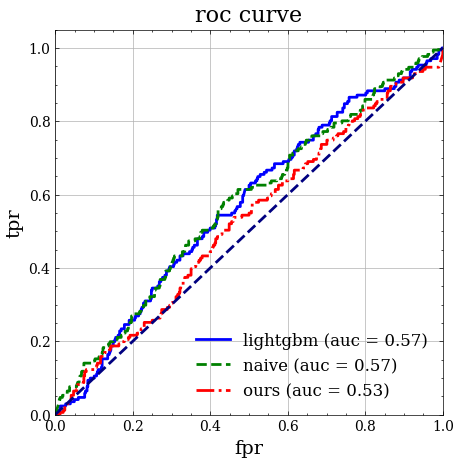

In [9]:
from lightgbm import LGBMClassifier
warnings.filterwarnings("ignore")

df_results = compute_additional_scores(df_results)

# define features and target
X = df_results[['target', 'world_model', 'shadow_model']]
y = df_results['label']

# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# model = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss', 
#     random_state=42
# )

model = LGBMClassifier(
    objective='binary',
    random_state=42,
    verbose=-1
)

# init cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')

print(f"cv acc: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
print(f"cv f1: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

# cross-validated predicted probabilities for xgboost
y_pred_proba_model = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]
y_pred_model = cross_val_predict(model, X, y, cv=cv, method='predict') 

# roc auc for xgboost
roc_auc_model = roc_auc_score(y, y_pred_proba_model)
print(f"Model AUC: {roc_auc_model:.4f}")

y_pred_proba_naive = np.zeros(len(y))
y_pred_proba_ours = np.zeros(len(y))

# cross-validation manually to compute "naive" and "ours" scores
for train_idx, test_idx in cv.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train_cv, y_train_cv)

    prob_target = model.predict_proba(X_test_cv)[:, 1]
    prob_shadow = X_test_cv['shadow_model']

    likelihood_ratio_cv = prob_target / (prob_shadow)

    # compute "naive" score
    # TODO: weird, negating the likelihood ratio is actually very good
    naive_score_cv = - likelihood_ratio_cv # + 1e-10)  # epsilon to avoid division by zero
    # naive_score_cv = prob_shadow / prob_target

    # compute "ours" score
    p_s_in_D_cv = likelihood_ratio_to_probability(likelihood_ratio_cv)
    our_score_cv = (X_test_cv['world_model'] - prob_shadow * (1 - p_s_in_D_cv)) / (p_s_in_D_cv) # + 1e-10)

    y_pred_proba_naive[test_idx] = naive_score_cv
    y_pred_proba_ours[test_idx] = our_score_cv

y_pred_proba_naive = np.nan_to_num(y_pred_proba_naive)
y_pred_proba_ours = np.nan_to_num(y_pred_proba_ours)

# TODO: don't actually think we need this scaling
# scaler = MinMaxScaler()
# y_pred_proba_naive_scaled = scaler.fit_transform(y_pred_proba_naive.reshape(-1, 1)).ravel()
# y_pred_proba_ours_scaled = scaler.fit_transform(y_pred_proba_ours.reshape(-1, 1)).ravel()

y_pred_proba_naive_scaled = y_pred_proba_naive
y_pred_proba_ours_scaled = y_pred_proba_ours

roc_auc_naive = roc_auc_score(y, y_pred_proba_naive_scaled)
print(f"naive auc: {roc_auc_naive:.4f}")

roc_auc_ours = roc_auc_score(y, y_pred_proba_ours_scaled)
print(f"ours auc: {roc_auc_ours:.4f}")

fpr_model, tpr_model, _ = roc_curve(y, y_pred_proba_model)
fpr_naive, tpr_naive, _ = roc_curve(y, y_pred_proba_naive_scaled)
fpr_ours, tpr_ours, _ = roc_curve(y, y_pred_proba_ours_scaled)

plt.style.use(['science'])
plt.rc('text', usetex=False)

plt.figure(figsize=(5, 5))

plt.plot(fpr_model, tpr_model, color='blue', lw=2, label=f'lightgbm (auc = {roc_auc_model:.2f})')
plt.plot(fpr_naive, tpr_naive, color='green', lw=2, linestyle='--', label=f'naive (auc = {roc_auc_naive:.2f})')
plt.plot(fpr_ours, tpr_ours, color='red', lw=2, linestyle='-.', label=f'ours (auc = {roc_auc_ours:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('fpr', fontsize=14)
plt.ylabel('tpr', fontsize=14)
plt.title('roc curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

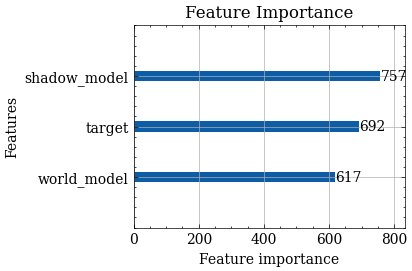

In [10]:
import matplotlib.pyplot as plt
import lightgbm

lightgbm.plot_importance(model)
plt.title('Feature Importance')
plt.show()

\cats with more than 20 examples:
['B-Sign_symptom', 'B-Disease_disorder', 'B-Medication', 'B-Biological_structure', 'B-Detailed_description', 'B-Diagnostic_procedure']
metrics for category: B-Sign_symptom
metrics for category: B-Disease_disorder
metrics for category: B-Medication
metrics for category: B-Biological_structure
metrics for category: B-Detailed_description
metrics for category: B-Diagnostic_procedure


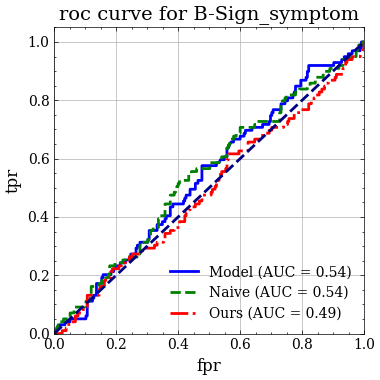

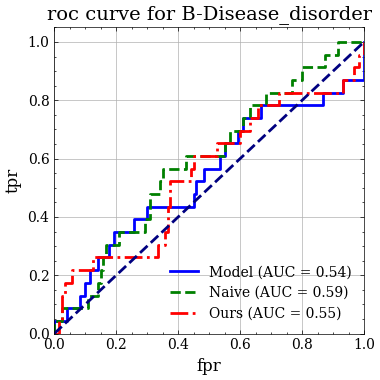

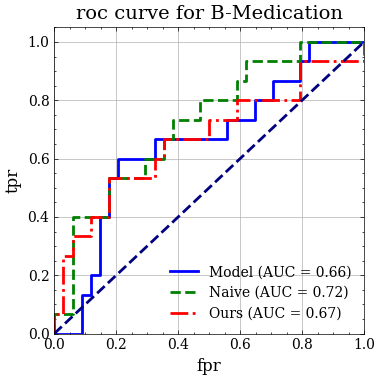

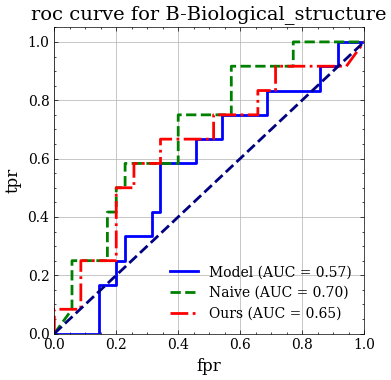

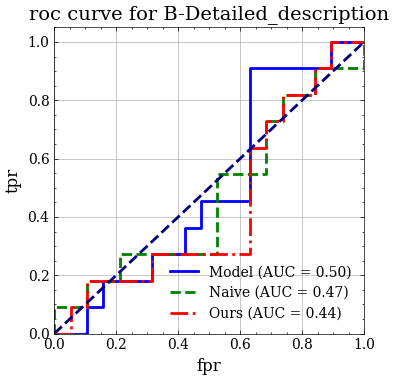

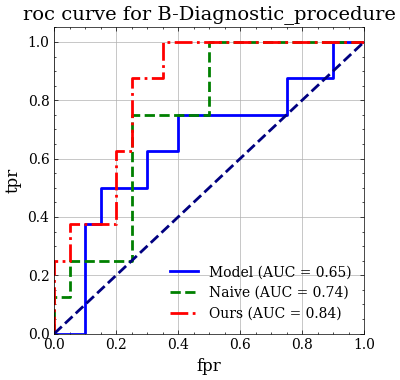


per cat summary:
                 category  accuracy  f1 Score   roc auc
0          B-Sign_symptom  0.646707  0.223684  0.535719
1      B-Disease_disorder  0.790210  0.117647  0.541304
2            B-Medication  0.653061  0.260870  0.656863
3  B-Biological_structure  0.638298  0.000000  0.569048
4  B-Detailed_description  0.533333  0.222222  0.497608
5  B-Diagnostic_procedure  0.714286  0.333333  0.650000


In [11]:
from sklearn.metrics import accuracy_score, f1_score
# per-category analysis 

# cats with more than 20 examples
category_counts = df_results['category'].value_counts()
categories_to_analyze = category_counts[category_counts > 20].index.tolist()

print("\cats with more than 20 examples:")
print(categories_to_analyze)

category_metrics = []

for category in categories_to_analyze:
    # filter or the current category
    df_cat = df_results[df_results['category'] == category]
    
    # ensure there are both classes present
    if df_cat['label'].nunique() < 2:
        print(f"skip category '{category}' as it does not have both classes")
        continue
    
    y_true_cat = df_cat['label']
    y_pred_cat = y_pred_model[df_cat.index]
    y_pred_proba_cat = y_pred_proba_model[df_cat.index]
    
    accuracy = accuracy_score(y_true_cat, y_pred_cat)
    f1 = f1_score(y_true_cat, y_pred_cat)
    roc_auc = roc_auc_score(y_true_cat, y_pred_proba_cat)
    
    category_metrics.append({
        'category': category,
        'accuracy': accuracy,
        'f1 Score': f1,
        'roc auc': roc_auc
    })
    
    print(f"metrics for category: {category}")

# gen ROC plots per cat
for category in categories_to_analyze:
    df_cat = df_results[df_results['category'] == category]
    
    if df_cat['label'].nunique() < 2:
        continue
    
    y_true = df_cat['label']
    
    y_pred_proba_model_cat = y_pred_proba_model[df_cat.index]
    
    y_pred_proba_naive_cat = y_pred_proba_naive[df_cat.index]
    y_pred_proba_ours_cat = y_pred_proba_ours[df_cat.index]
    
    fpr_model, tpr_model, _ = roc_curve(y_true, y_pred_proba_model_cat)
    fpr_naive, tpr_naive, _ = roc_curve(y_true, y_pred_proba_naive_cat)
    fpr_ours, tpr_ours, _ = roc_curve(y_true, y_pred_proba_ours_cat)
    
    roc_auc_model = roc_auc_score(y_true, y_pred_proba_model_cat)
    roc_auc_naive = roc_auc_score(y_true, y_pred_proba_naive_cat)
    roc_auc_ours = roc_auc_score(y_true, y_pred_proba_ours_cat)
    
    plt.figure(figsize=(4, 4))
    
    plt.plot(fpr_model, tpr_model, color='blue', lw=2, label=f'Model (AUC = {roc_auc_model:.2f})')
    plt.plot(fpr_naive, tpr_naive, color='green', lw=2, linestyle='--', label=f'Naive (AUC = {roc_auc_naive:.2f})')
    plt.plot(fpr_ours, tpr_ours, color='red', lw=2, linestyle='-.', label=f'Ours (AUC = {roc_auc_ours:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('fpr', fontsize=12)
    plt.ylabel('tpr', fontsize=12)
    plt.title(f'roc curve for {category}', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

metrics_df = pd.DataFrame(category_metrics)

print("\nper cat summary:")
print(metrics_df)



Naive Optimal Threshold: -276.9514 (FPR: 0.4344, TPR: 0.5789)
Ours Optimal Threshold: 0.0001 (FPR: 0.4611, TPR: 0.5380)

corr between prob mag and prediction success:

Technique: model_correct
  target_corr: 0.0253
  shadow_model_corr: 0.0082
  world_model_corr: 0.0174

Technique: naive_correct
  target_corr: -0.0974
  shadow_model_corr: -0.0981
  world_model_corr: -0.1105

Technique: ours_correct
  target_corr: -0.1161
  shadow_model_corr: -0.1330
  world_model_corr: -0.1272

stratified metrics by 'target' prob:
                       strata  accuracy  naive_accuracy  ours_accuracy  count
0  (-0.00099999822, 2.31e-05]  0.727273        0.825758       0.840909    132
1        (2.31e-05, 0.000131]  0.613636        0.681818       0.598485    132
2        (0.000131, 0.000533]  0.763359        0.511450       0.480916    131
3         (0.000533, 0.00207]  0.681818        0.431818       0.409091    132
4              (0.00207, 1.0]  0.613636        0.386364       0.356061    132


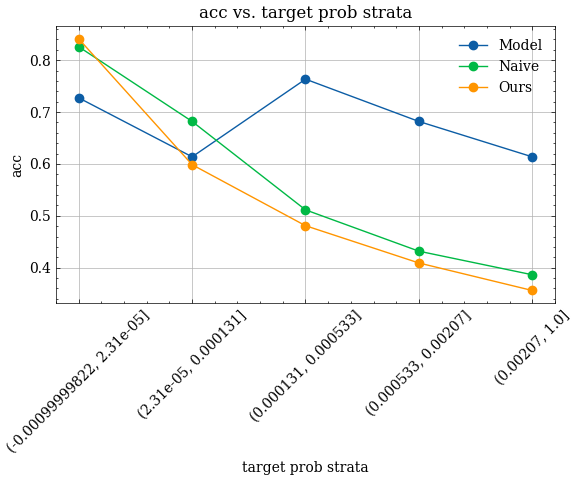


strata metrics by 'shadow_model' prob:
                               strata  accuracy  naive_accuracy  \
0  (-0.0009999998110000001, 2.84e-05]  0.746154        0.792308   
1                (2.84e-05, 0.000185]  0.736434        0.767442   
2                (0.000185, 0.000867]  0.684615        0.607692   
3                 (0.000867, 0.00299]  0.713178        0.317829   
4                      (0.00299, 1.0]  0.561538        0.353846   

   ours_accuracy  count  
0       0.792308    130  
1       0.775194    129  
2       0.484615    130  
3       0.294574    129  
4       0.346154    130  


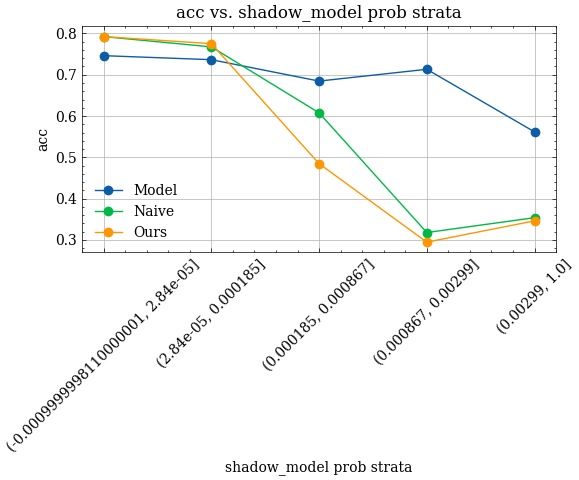


strata metrics by 'world_model' prob:
                        strata  accuracy  naive_accuracy  ours_accuracy  count
0  (-0.000999999772, 6.18e-06]  0.769231        0.823077       0.815385    130
1         (6.18e-06, 5.69e-05]  0.658915        0.697674       0.744186    129
2          (5.69e-05, 0.00025]  0.738462        0.607692       0.569231    130
3           (0.00025, 0.00132]  0.612403        0.418605       0.294574    129
4               (0.00132, 1.0]  0.661538        0.292308       0.269231    130


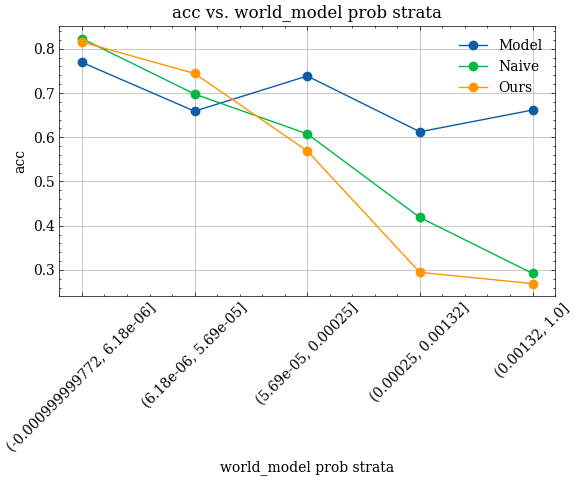

In [ ]:
# 'model_correct' to compare model predictions with true labels
df_results['model_correct'] = (y_pred_model == y).astype(int)

def optimal_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    J = tpr - fpr
    ix = np.argmax(J)
    optimal_thresh = thresholds[ix]
    return optimal_thresh, fpr[ix], tpr[ix]

# find an "optimal" threshold for 'naive_score'
naive_threshold, naive_fpr, naive_tpr = optimal_threshold(y, y_pred_proba_naive)
print(f"naive optimal thresh: {naive_threshold:.4f} (FPR: {naive_fpr:.4f}, TPR: {naive_tpr:.4f})")

# find an "optimal" threshold for 'ours_score'
ours_threshold, ours_fpr, ours_tpr = optimal_threshold(y, y_pred_proba_ours)
print(f"ours optimal thresh: {ours_threshold:.4f} (FPR: {ours_fpr:.4f}, TPR: {ours_tpr:.4f})")

# thresholds to define 'naive_correct' and 'ours_correct'
df_results['naive_correct'] = ((y_pred_proba_naive > naive_threshold).astype(int) == y).astype(int)
df_results['ours_correct'] = ((y_pred_proba_ours > ours_threshold).astype(int) == y).astype(int)

# TEST 1: CHECKING CORRELATION BETWEEN PROB AND MAKING CORRECT PRED 
correlations = {}

for technique in ['model_correct', 'naive_correct', 'ours_correct']:
    correlations[technique] = {
        'target_corr': df_results['target'].corr(df_results[technique]),
        'shadow_model_corr': df_results['shadow_model'].corr(df_results[technique]),
        'world_model_corr': df_results['world_model'].corr(df_results[technique])
    }

print("\ncorr between prob mag and prediction success:")
for technique, corr_values in correlations.items():
    print(f"\ntechnique: {technique}")
    for feature, corr in corr_values.items():
        print(f"  {feature}: {corr:.4f}")

# TEST 2: STRATIFY BY PROB MAGNITUDES AND CHECK SUCCESS RATE
def stratify_and_evaluate(df, feature, bins=5):
    try:
        df['strata'] = pd.qcut(df[feature], q=bins, duplicates='drop')
    except ValueError as e:
        print(f"error stratifying by {feature}: {e}")
        return pd.DataFrame()
    
    strata_metrics = df.groupby('strata').agg(
        accuracy=('model_correct', 'mean'),
        naive_accuracy=('naive_correct', 'mean'),
        ours_accuracy=('ours_correct', 'mean'),
        count=('model_correct', 'count')
    ).reset_index()
    return strata_metrics

strata_target = stratify_and_evaluate(df_results, 'target', bins=5)
print("\nstratified metrics by 'target' prob:")
print(strata_target)

# plot acc vs. target prob
if not strata_target.empty:
    plt.figure(figsize=(6, 5))
    plt.plot(strata_target['strata'].astype(str), strata_target['accuracy'], marker='o', label='Model')
    plt.plot(strata_target['strata'].astype(str), strata_target['naive_accuracy'], marker='o', label='Naive')
    plt.plot(strata_target['strata'].astype(str), strata_target['ours_accuracy'], marker='o', label='Ours')
    plt.xlabel('target prob strata')
    plt.ylabel('acc')
    plt.title('acc vs. target prob strata')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for feature in ['shadow_model', 'world_model']:
    strata = stratify_and_evaluate(df_results, feature, bins=5)
    if strata.empty:
        continue
    print(f"\nstrata metrics by '{feature}' prob:")
    print(strata)
    
    plt.figure(figsize=(6, 5))
    plt.plot(strata['strata'].astype(str), strata['accuracy'], marker='o', label='Model')
    plt.plot(strata['strata'].astype(str), strata['naive_accuracy'], marker='o', label='Naive')
    plt.plot(strata['strata'].astype(str), strata['ours_accuracy'], marker='o', label='Ours')
    plt.xlabel(f'{feature} prob strata')
    plt.ylabel('acc')
    plt.title(f'acc vs. {feature} prob strata')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
